In [3]:
from __future__ import annotations

from dataclasses import dataclass, field

from IPython.display import Image, display
from pydantic import BaseModel, Field
from pydantic_ai import Agent
from pydantic_ai import messages as _messages
from pydantic_graph import BaseNode, End, Graph, GraphRunContext

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
class UserPreferences(BaseModel):
    summary: list[str] = Field(description="The summary of user preferences")


agent = Agent(
    model="google-gla:gemini-1.5-flash",
    result_type=UserPreferences | str,  # type: ignore
    system_prompt=(
        "You're goal is to help the user to find the best smartphone model based on his preferences.\n"
        "- Ask questions one at a time.\n"
        "- Ask no more than 4 questions, but you may finish earlier if you gather enough information.\n"
        "- Focus on key aspects like budget, preferred OS, camera quality, battery life, and screen size.\n"
        "- Be concise but friendly in your questions.\n"
        "- After gathering information, provide a summary of preferences in the result.\n"
        "- Do not recommend specific phone models, just summarize preferences.\n"
        "- If user provides preferences without being asked, incorporate them into your understanding.\n"
        "Return the UserPreferences once you have gathered all the information."
    ),
)


@dataclass
class GraphState:
    message_history: list[_messages.ModelMessage] = field(default_factory=list)


@dataclass
class Ask(BaseNode[GraphState, None, UserPreferences]):
    user_prompt: str = "I'm thinking of buying a new smartphone"

    async def run(self, ctx: GraphRunContext[GraphState]) -> End[UserPreferences] | Ask:
        if self.user_prompt.lower() == "q":
            return End(UserPreferences(summary=["Nice camera"]))
        res = await agent.run(user_prompt=self.user_prompt, message_history=ctx.state.message_history)
        ctx.state.message_history = res.all_messages()
        if isinstance(res.data, UserPreferences):
            return End(res.data)
        return Ask(user_prompt=res.data)


In [8]:
phone_graph = Graph(nodes=[Ask])

In [ ]:
state = GraphState()
node = Ask()
history = []
while True:
    node = await phone_graph.next(node, history, state=state)
    if isinstance(node, Ask):
        node.user_prompt = input(f"{node.user_prompt}   > ")
    else:
        break

In [11]:
[e.data_snapshot() for e in history]

[Ask(user_prompt="I'm thinking of buying a new smartphone"),
 Ask(user_prompt='1500'),
 Ask(user_prompt='ios'),
 Ask(user_prompt='battery')]

In [14]:
state.message_history

[ModelRequest(parts=[SystemPromptPart(content="You're goal is to help the user to find the best smartphone model based on his preferences.\n- Ask questions one at a time.\n- Ask no more than 4 questions, but you may finish earlier if you gather enough information.\n- Focus on key aspects like budget, preferred OS, camera quality, battery life, and screen size.\n- Be concise but friendly in your questions.\n- After gathering information, provide a summary of preferences in the result.\n- Do not recommend specific phone models, just summarize preferences.\n- If user provides preferences without being asked, incorporate them into your understanding.\nReturn the UserPreferences once you have gathered all the information.", dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content="I'm thinking of buying a new smartphone", timestamp=datetime.datetime(2025, 2, 10, 21, 20, 38, 219517, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[T

In [9]:
@dataclass
class GraphDeps:
    name: str
    age: int | None = None


@dataclass
class DivisibleBy5(BaseNode[None, GraphDeps, str]):
    foo: int

    async def run(self, ctx: GraphRunContext[None, GraphDeps]) -> Increment | End[str]:
        if self.foo % 5 == 0:
            ctx.deps.age = self.foo
            return End(f"{ctx.deps.name}'s age is divisible by 5")
        else:
            return Increment(self.foo)


@dataclass
class Increment(BaseNode[None, GraphDeps]):
    foo: int

    async def run(self, ctx: GraphRunContext[None, GraphDeps]) -> DivisibleBy5:
        return DivisibleBy5(self.foo + 1)


fives_graph = Graph(nodes=[DivisibleBy5, Increment])


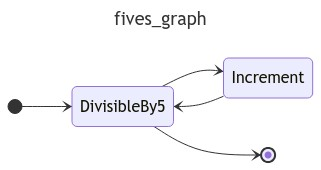

In [10]:
display(Image(fives_graph.mermaid_image(start_node=DivisibleBy5, theme="default", direction="LR")))

In [12]:
deps = GraphDeps(name="hamza")
res, history = await fives_graph.run(Increment(1), deps=deps)


In [13]:
history

[NodeStep(state=None, node=Increment(foo=1), start_ts=datetime.datetime(2025, 1, 30, 20, 35, 11, 797436, tzinfo=datetime.timezone.utc), duration=2.2550084395334125e-06, kind='node'),
 NodeStep(state=None, node=DivisibleBy5(foo=2), start_ts=datetime.datetime(2025, 1, 30, 20, 35, 11, 797518, tzinfo=datetime.timezone.utc), duration=1.8099963199347258e-06, kind='node'),
 NodeStep(state=None, node=Increment(foo=2), start_ts=datetime.datetime(2025, 1, 30, 20, 35, 11, 797593, tzinfo=datetime.timezone.utc), duration=8.630013326182961e-07, kind='node'),
 NodeStep(state=None, node=DivisibleBy5(foo=3), start_ts=datetime.datetime(2025, 1, 30, 20, 35, 11, 797664, tzinfo=datetime.timezone.utc), duration=1.0229996405541897e-06, kind='node'),
 NodeStep(state=None, node=Increment(foo=3), start_ts=datetime.datetime(2025, 1, 30, 20, 35, 11, 797733, tzinfo=datetime.timezone.utc), duration=8.080096449702978e-07, kind='node'),
 NodeStep(state=None, node=DivisibleBy5(foo=4), start_ts=datetime.datetime(2025, 

In [14]:
deps

GraphDeps(name='hamza', age=5)